# Create Voronoid based on Towers

Created by: Orsi Vasarhelyi

Last updated: 19.07.2018.

Code based on: https://github.com/DSSG-EUROPE/florence/blob/master/dev/notebooks/florence-shape-file-plots.ipynb

In [2]:
% matplotlib inline

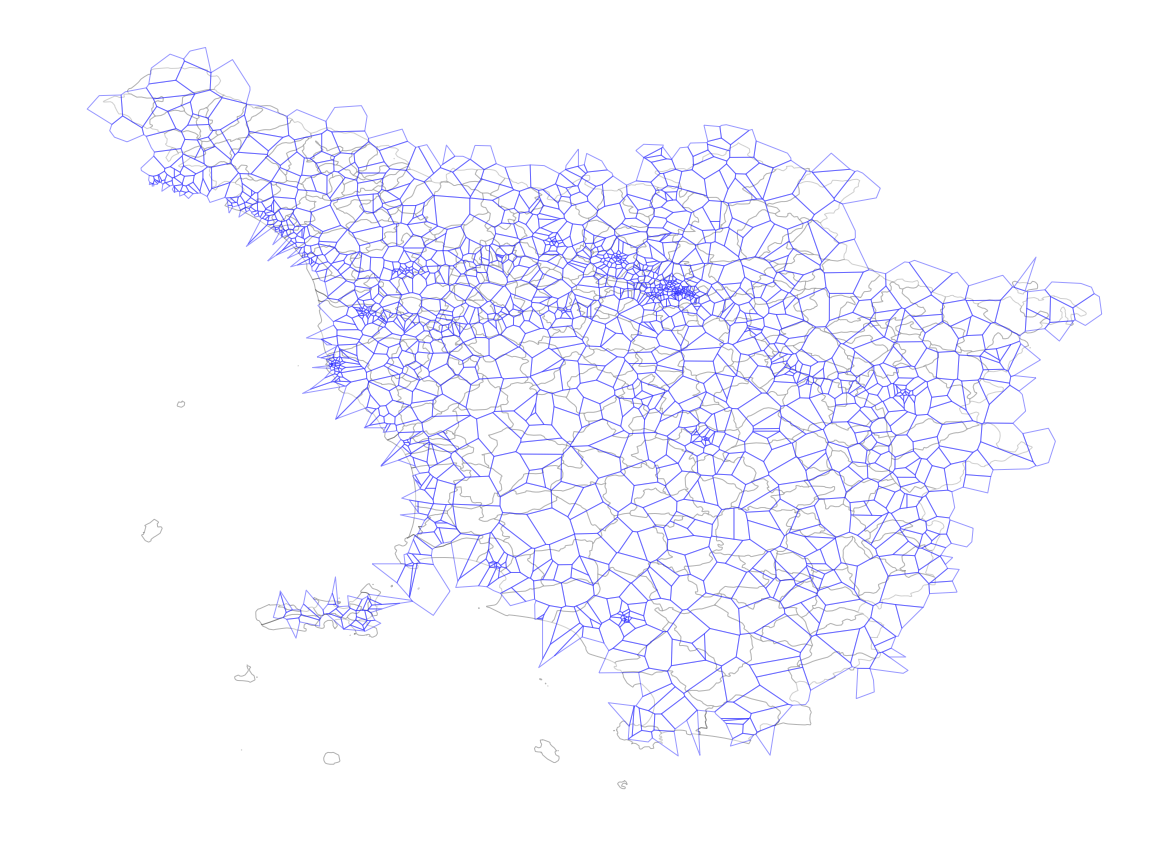

In [3]:
# coding: utf-8

# Create Voronois for tower locations
# Created by: Orsi Vasarhelyi
# Contact: orsolya.vasarhelyi@gmail.com
# Last updated: 19.07.2018.
# 
# Code based on: https://github.com/DSSG-EUROPE/florence/blob/master/dev/notebooks/florence-shape-file-plots.ipynb

# Imports

## connect db
import sys
sys.path.append("..")


#from .application.app.folder.file import func_name
from connect_db import db_connection

#read shapefiles
import json
sys.path.insert(0, '/mnt/data/ovasarhelyi/TPT_tourism/new_codebase/src/utils/read_shapefiles/')
from read_shapefiles import *

## vornois
import pandas as pd
import geopandas as gpd
import numpy as np
import shapely as sp
from scipy.spatial import Voronoi, voronoi_plot_2d

#ploting
import matplotlib.pyplot as plt


pathout='/mnt/data/shared/'


query_lonlat = """select loc.location_id, loc.lat, loc.lon, dic.region
from tpt.tuscany.location as loc
inner join  tpt.tuscany.location_dictionary as dic
on dic.location_id=loc.location_id
""" 

# Helper functions


path_shapefiles,regions,provinces,municipalities,crs=read_shapefile_data(pathout,'shape_files_path.json')

def create_connection(username):
    cred_location = "/mnt/data/{}/utils/data_creds_redshift.json.nogit".format(username)
    db = db_connection.DBConnection(cred_location)
    return db


def read_location_table(username,query):
    db=create_connection(username)
    locations = db.sql_query_to_data_frame(query_lonlat, cust_id=True)
    locations['lat']=locations.lat.astype(float)
    locations['lon']=locations.lon.astype(float)
    return locations

def locations_as_geo(locations):
    geo_points = [sp.geometry.Point(xy) for xy in zip(locations.lon, locations.lat)]
    cdr_geo = gpd.GeoDataFrame(locations, crs=crs, geometry = geo_points)
    cdr_geo = cdr_geo.to_crs(epsg=4326)
    return cdr_geo

# Vornoi Creation
def visualize_vornois(voronoi_geo_in_tusc, file_name, pathout, municipalities, crs):
    """Visualize vornoi results on the Tuscany map with municipalities"""

    fig, ax = plt.subplots(figsize=(20, 15), frameon=False)
    ax.axis('off')

    df_mun_tusc=read_shapefiles_in(True, path_shapefiles, municipalities, crs)
    df_mun_tusc.plot(ax=ax, edgecolor='black', color='white', alpha=0.3, figsize=(20, 15))
    ax=voronoi_geo_in_tusc.plot(ax=ax, edgecolor='blue', color='white', figsize=(20, 15), alpha=0.4)

    with open(pathout+file_name, 'wb') as outfile:
        fig.canvas.print_png(outfile)


def towers_vornois_in_tuscany(cdr_geo, crs, path_shapefiles, regions):
    """Takes the locations dataframe convert into a geodataframe
    than calculate the tower vornois around tower coordinates and cut out tuscany with a buffer """
    
    tower_points = np.array(cdr_geo.geometry)
    towers = [np.array([point.x, point.y]) for point in tower_points]
    
    #create vornois
    vor = Voronoi(towers)
    lines = [
        sp.geometry.LineString(vor.vertices[line])
        for line in vor.ridge_vertices
        if -1 not in line
    ]

    voronoi_polys = sp.ops.polygonize(lines)
    voronoi_geo = gpd.GeoDataFrame(crs=crs, geometry=list(voronoi_polys)).to_crs(epsg=4326)
    
    #add tuscany shapefile
    df_reg_tusc=read_shapefiles_in(True, path_shapefiles, regions, crs)
    voronoi_geo_in_tusc = voronoi_geo[voronoi_geo.within(df_reg_tusc.unary_union.buffer(0.091))]
    # visualize
    visualize_vornois(voronoi_geo_in_tusc, 'voronoi_tusc.png', pathout, municipalities, crs)

    return voronoi_geo_in_tusc


def export_location_with_voronois(crs, path_shapefiles, regions, pathout, file_name):
    """Exports location_ids with the vornoi shapes"""
    
    locations=read_location_table('ovasarhelyi',query_lonlat)
    cdr_geo = locations_as_geo(locations)
    voronoi_geo_in_tusc = towers_vornois_in_tuscany(locations, crs, path_shapefiles, regions)
    cdr_geo.crs=crs
    voronoi_geo_in_tusc.crs=crs
    j=gpd.sjoin(cdr_geo, voronoi_geo_in_tusc, how='right')
    j['region']=j['region'].astype(float)
    j['location_id']=j['location_id'].astype(float)
    locations_with_voronois=j[['location_id', 'lat', 'lon', 'region', 'geometry']].set_index('location_id')
    locations_with_voronois.to_file(pathout+file_name)



export_location_with_voronois(crs, path_shapefiles, regions, pathout, 'locations_with_voronois_shapes4.shp')


In [5]:
gpd.read_file(pathout+'locations_with_voronois_shapes4.shp').head()

,lat,lon,region,geometry
0,42.7587,10.3179,9.0,"POLYGON ((10.33561368734884 42.76767352389292,..."
1,42.7587,10.3179,9.0,"POLYGON ((10.33561368734884 42.76767352389292,..."
2,42.7587,10.3179,9.0,"POLYGON ((10.33561368734884 42.76767352389292,..."
3,42.7587,10.3179,9.0,"POLYGON ((10.33561368734884 42.76767352389292,..."
4,42.7587,10.3179,9.0,"POLYGON ((10.33561368734884 42.76767352389292,..."
